In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import wfdb, os, neurokit2 as nk
from ggs import GGS
from scipy.io import arff
from scipy.signal import savgol_filter
from datetime import timedelta
pd.options.mode.chained_assignment = None

def interpolate_ts(df, freq):
    reindexed_df = df.resample(freq).mean()
    reindexed_df = reindexed_df.reindex(
        pd.date_range(
            start=reindexed_df.index.min(),
            end=reindexed_df.index.max(),
            freq=freq
        )
    ).interpolate(method='time').bfill()
    return reindexed_df

def process_ts(df, freq):
    df["Time_Light"] = pd.to_datetime(
        df["Time_Light"],
        format='%H:%M:%S:%f'
    )
    df = df.drop_duplicates().set_index("Time_Light")
    return interpolate_ts(df, freq)

def plot_ggs(signal, bps):
    plt.figure(figsize=(20, 4))
    plt.plot(signal)
    if isinstance(bps[0], list):
        bps = bps[-1]
    for x in bps:
        plt.axvline(x=x, linestyle="--", color="black")
    plt.show()

### DriveDB

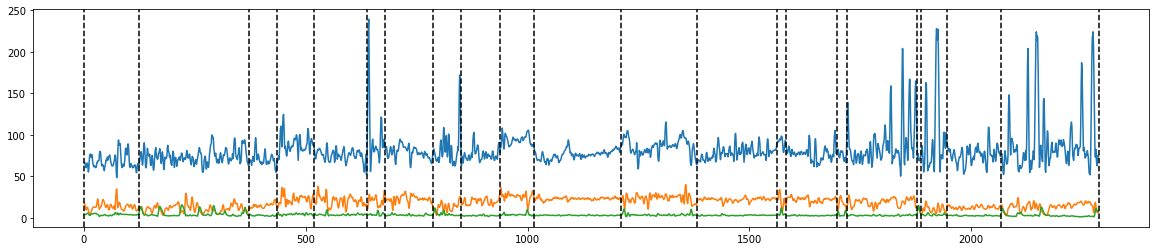

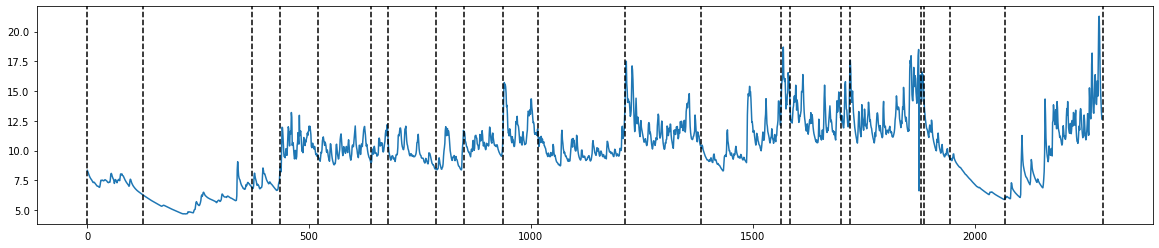

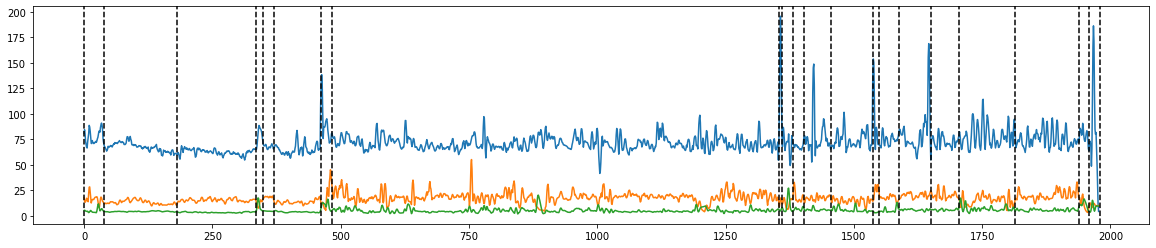

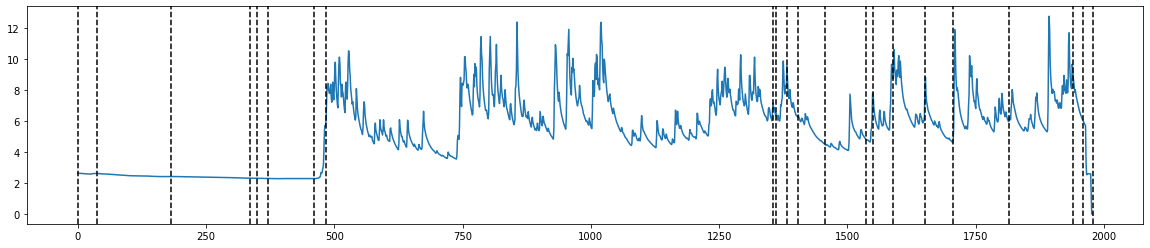

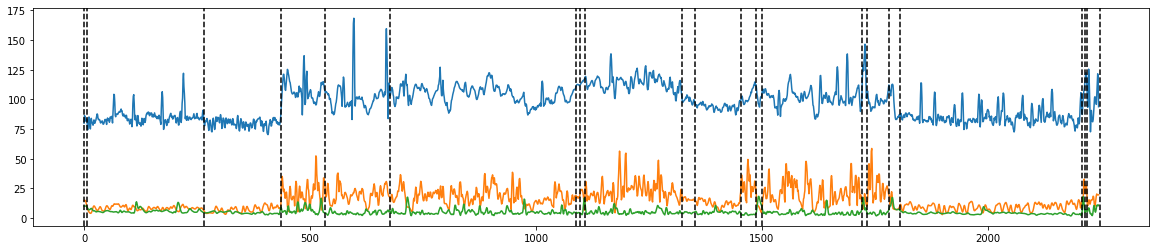

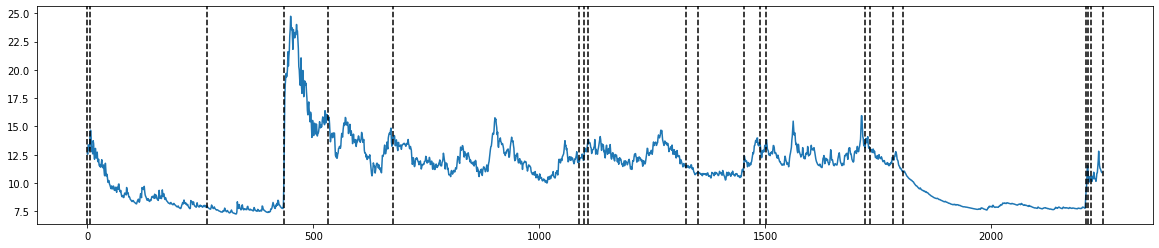

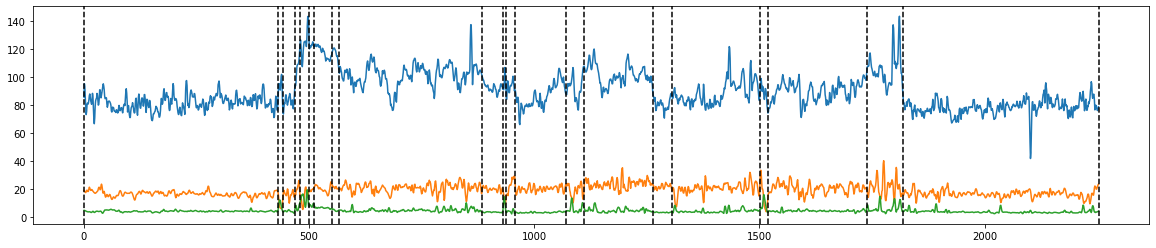

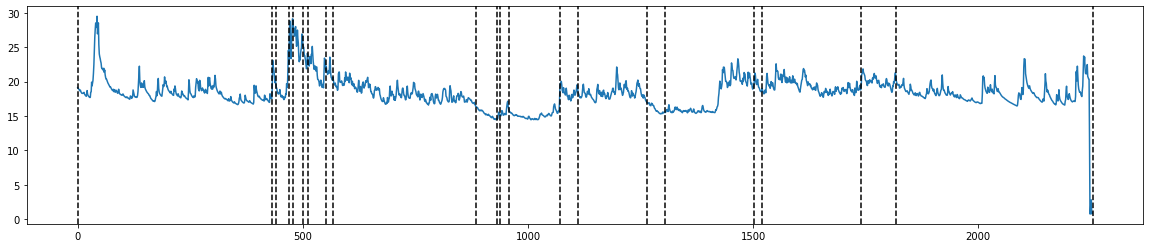

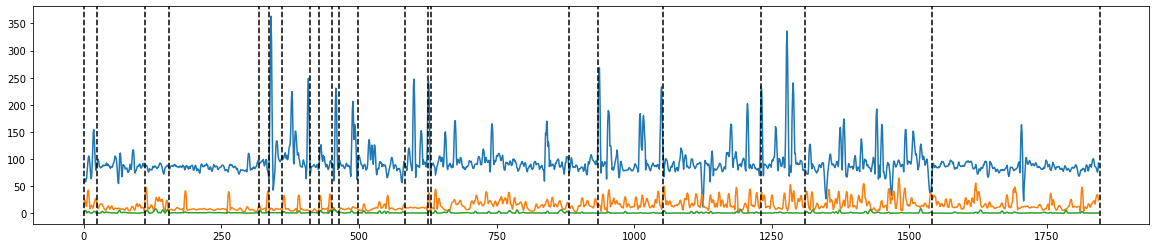

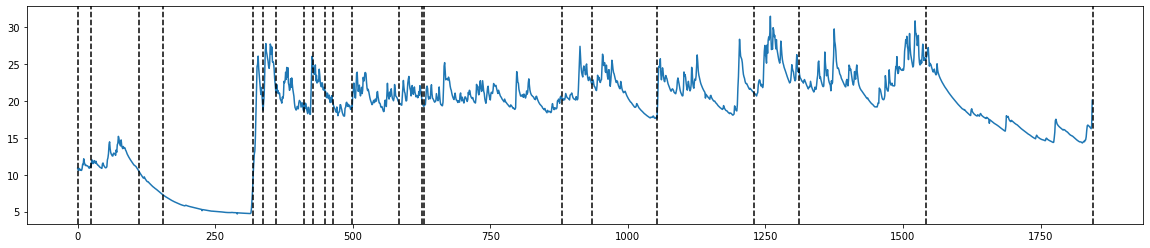

We are done adding breakpoints!
[0, 6, 432, 441, 448, 459, 485, 510, 514, 519, 554, 560, 654, 659, 785]


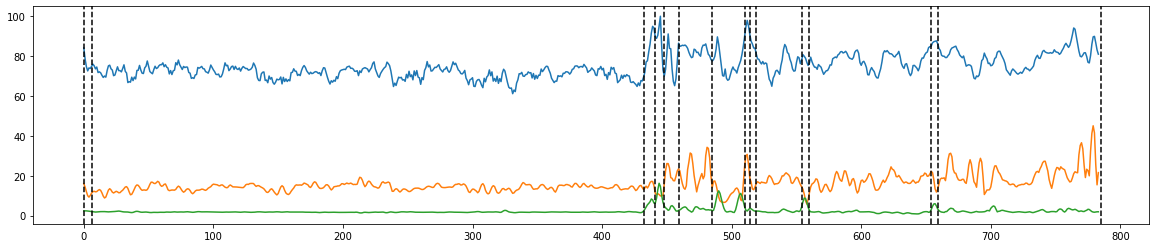

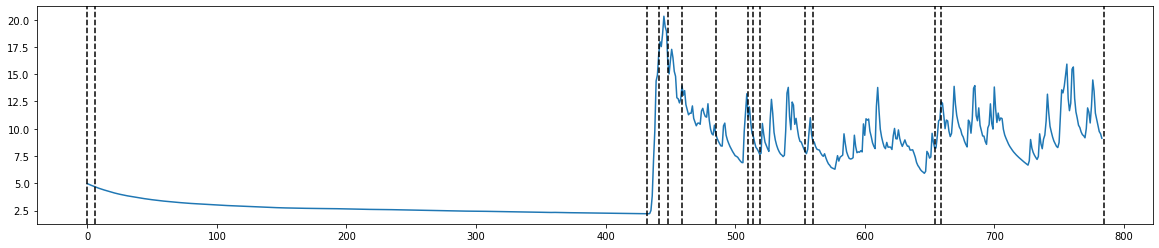

We are done adding breakpoints!
[0, 2, 5, 8, 36, 52, 218, 281, 287, 293, 298, 323, 702, 704, 711]


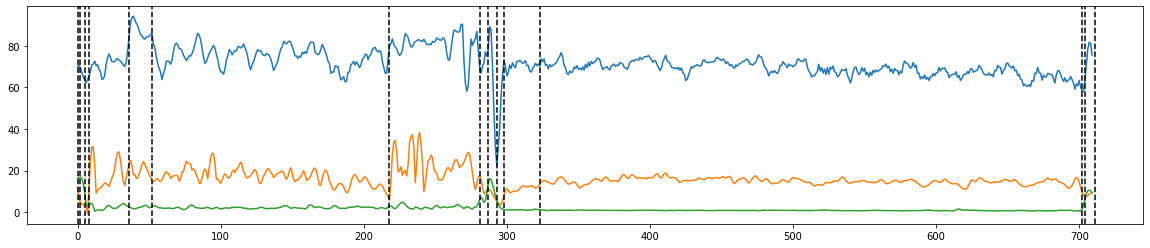

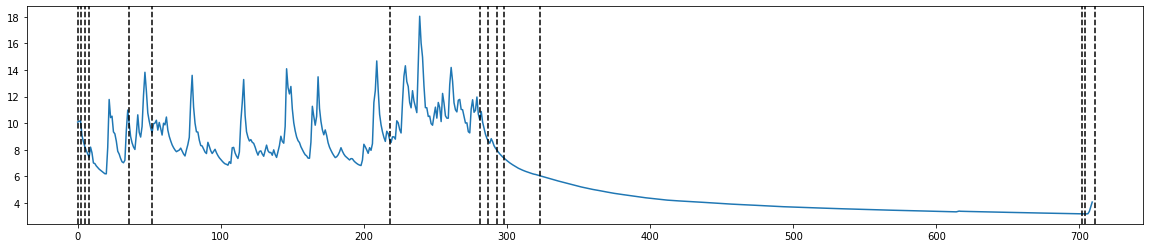

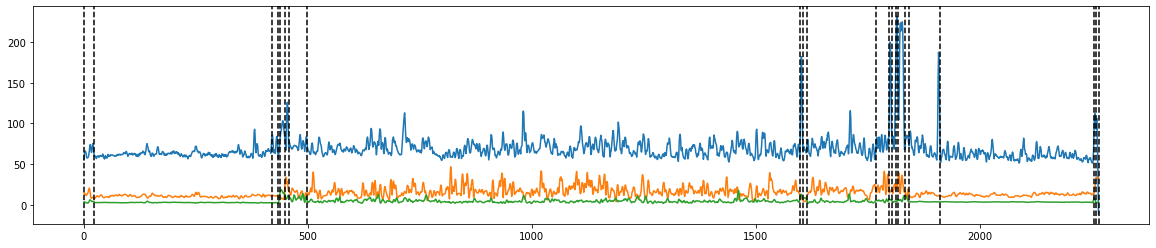

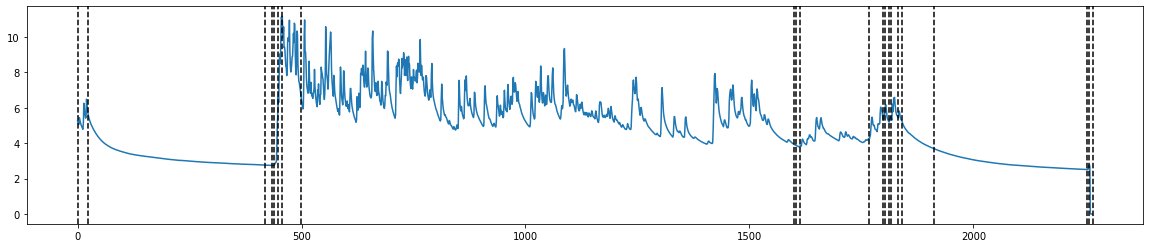

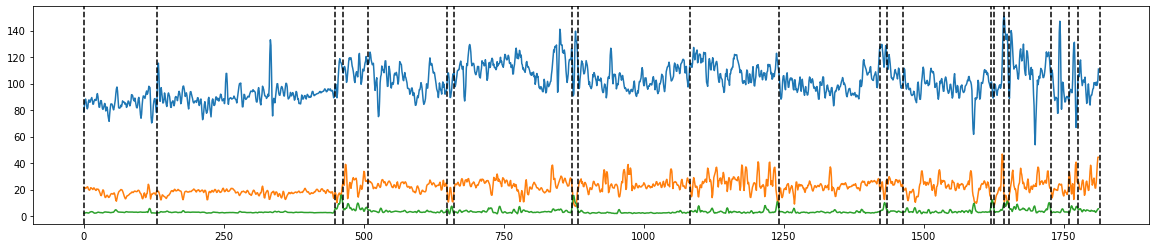

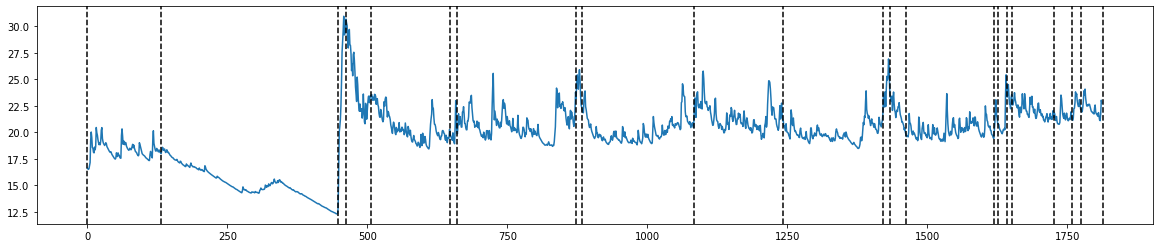

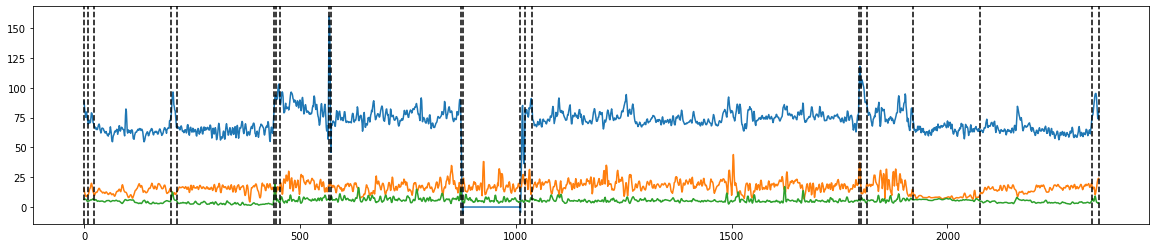

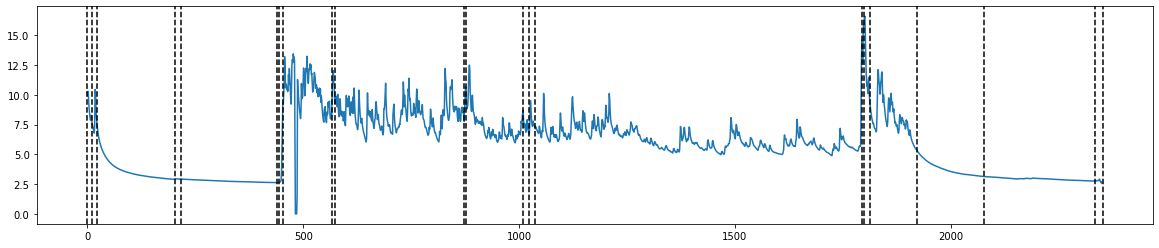

We are done adding breakpoints!
[0, 4, 16, 147, 566, 571, 575, 577, 618, 688, 1888, 2299, 2301, 2312, 2319]


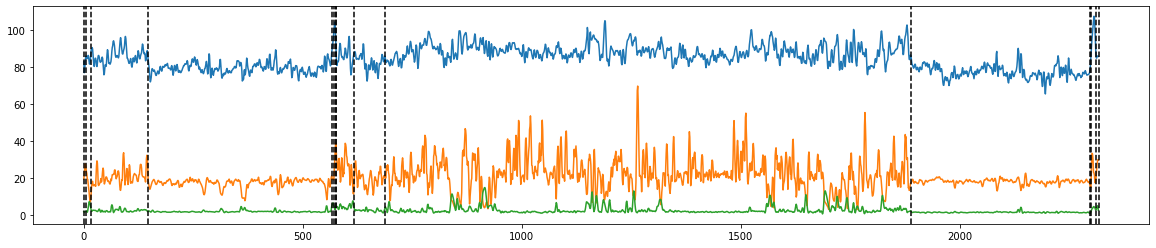

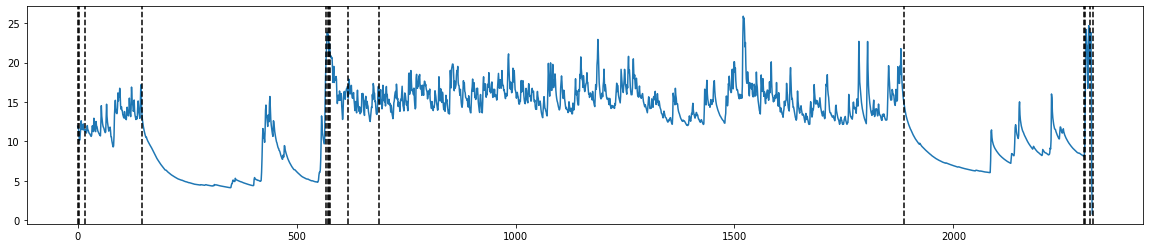

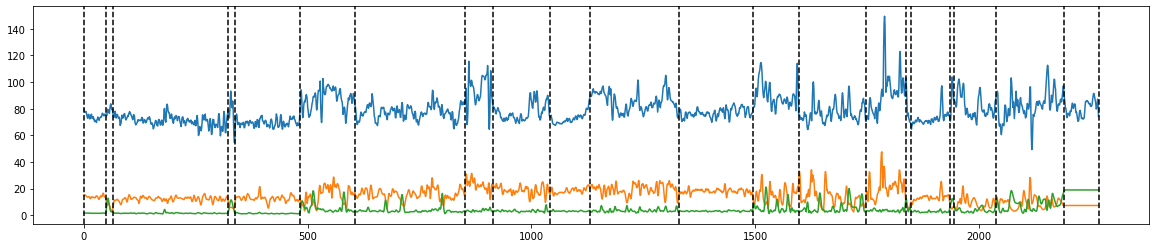

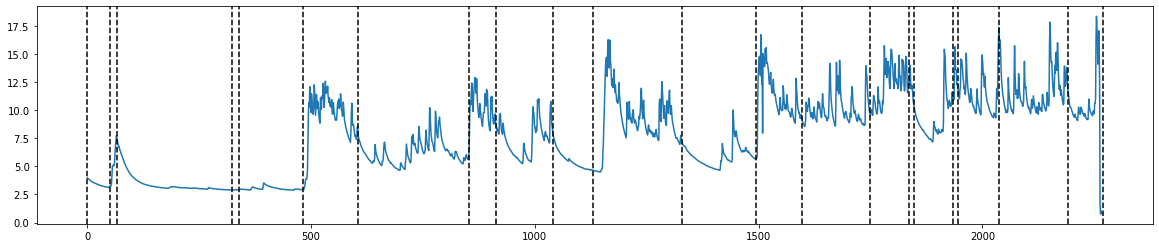

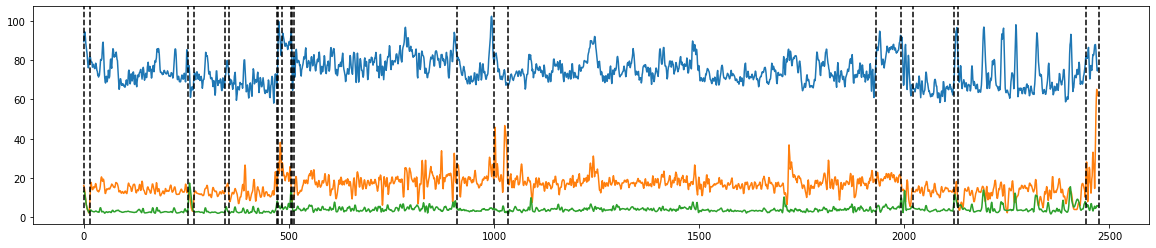

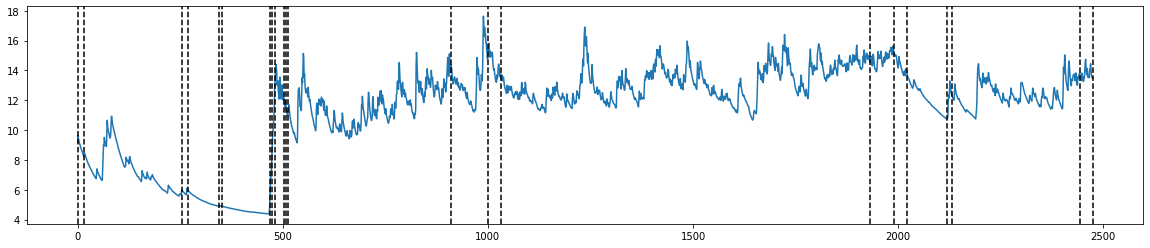

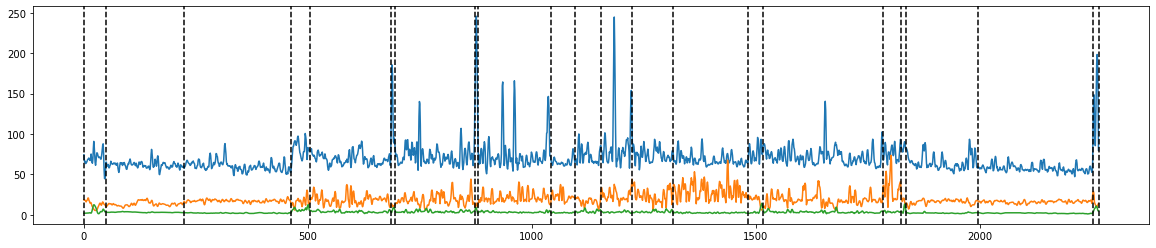

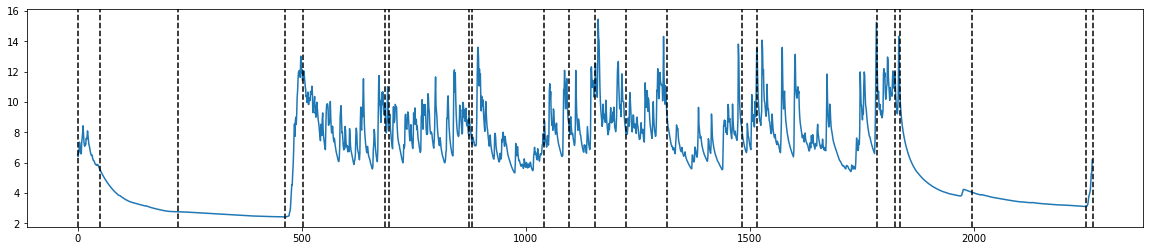

We are done adding breakpoints!
[0, 29, 46, 154, 551, 557, 938, 1130, 1135, 1140, 1178, 1309, 1488, 1500, 1525, 1871, 1875, 1883, 1934, 1946, 2343]


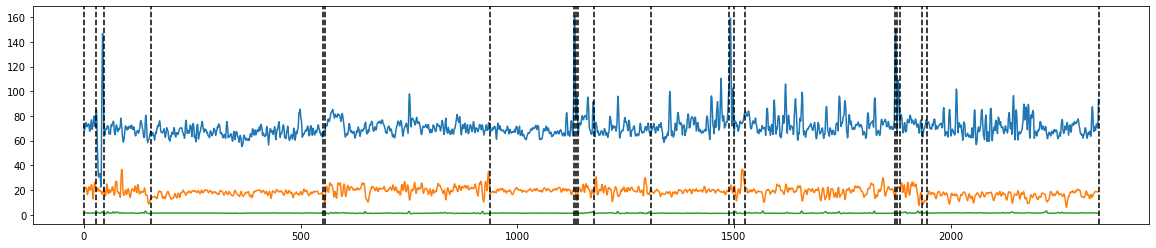

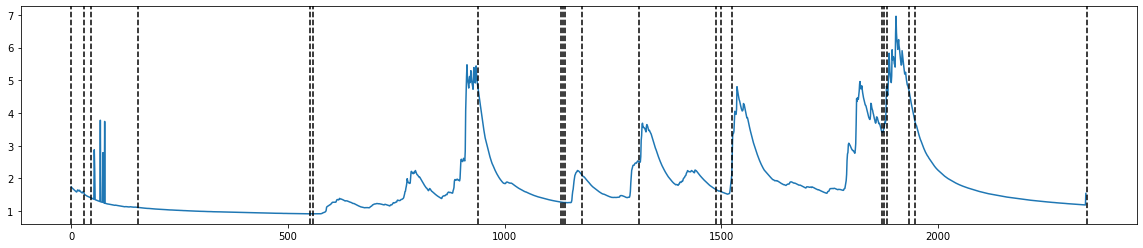

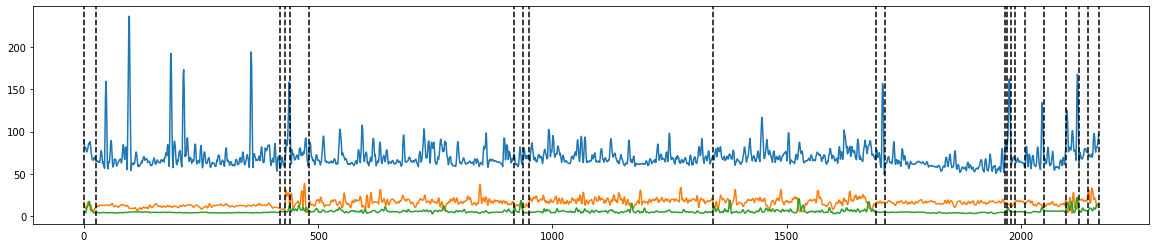

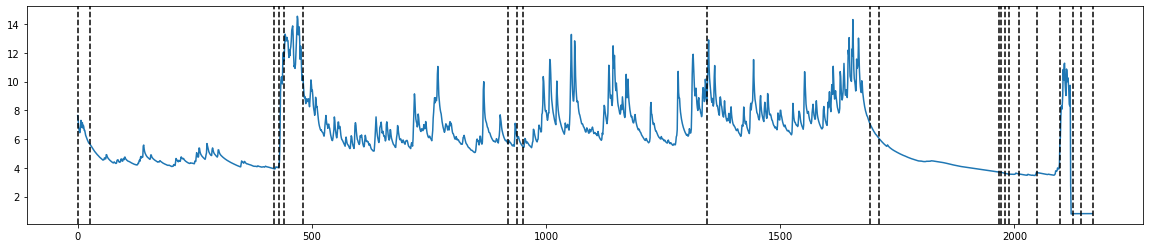

In [3]:
# sensors: ECG too low fs, EMG errors, GSR ready (hand), HR ready, marker wtf, RESP processed
# final config: GSR (ground), HR, RESP_amp, RESP_rate
datapath = "/home/kavra/Datasets/physionet.org/files/drivedb/1.0.0/"

for file in os.listdir(datapath):
    if file.endswith(".dat"):
        signals, fields = wfdb.rdsamp(datapath + os.path.splitext(file)[0])
        this_df = pd.DataFrame(signals, columns=fields["sig_name"])
        try:
            signal = this_df["RESP"].to_numpy()
            _ = this_df["HR"].to_numpy()
        except:
            continue
        out, info = nk.rsp_process(signal, sampling_rate=fields["fs"])
        this_df["RESP_amp"] = out[["RSP_Amplitude"]]
        this_df["RESP_rate"] = out[["RSP_Rate"]]

        this_df.index = pd.date_range(start='1/1/2022', periods=len(this_df), freq='0.06S')
        this_df = this_df.resample("2S").mean()

        this_data = this_df[["HR", "RESP_rate", "RESP_amp"]].to_numpy()    
        this_data = savgol_filter(this_data, 7, 3, axis=0)
        this_data = this_data.T if len(this_data.shape) != 1 else this_data[None, ...]
        bps, _ = GGS(this_data, Kmax=20, lamb=5)

        plot_ggs(this_data.T, bps)
        try: plot_ggs(this_df["hand GSR"].to_numpy(), bps)
        except: plot_ggs(this_df["foot GSR"].to_numpy(), bps)

### HCI Driving

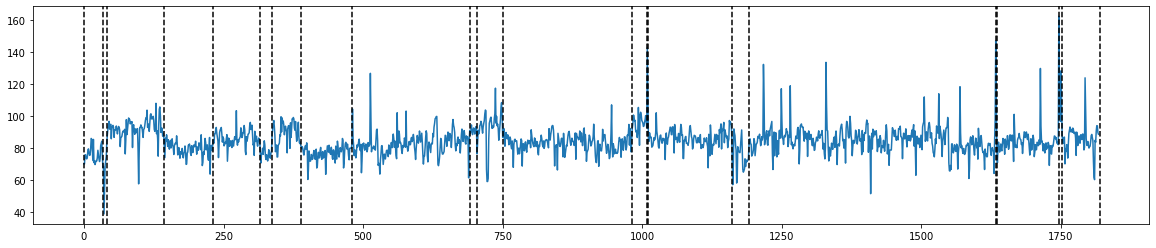

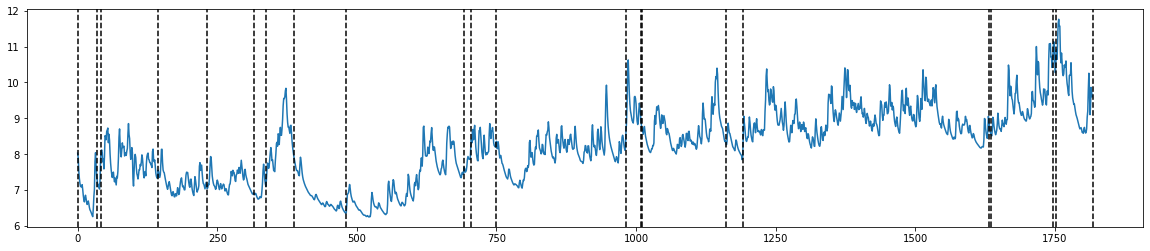

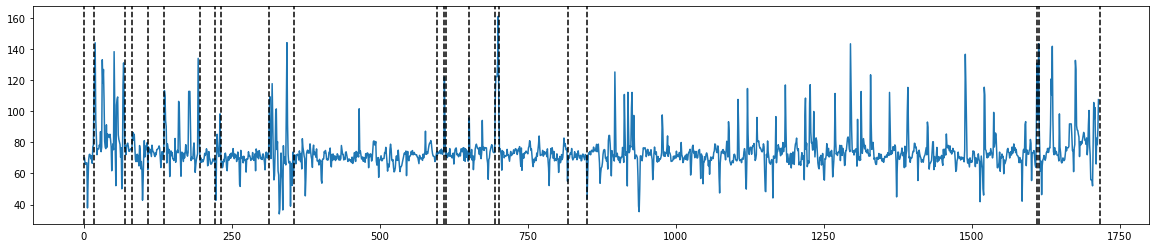

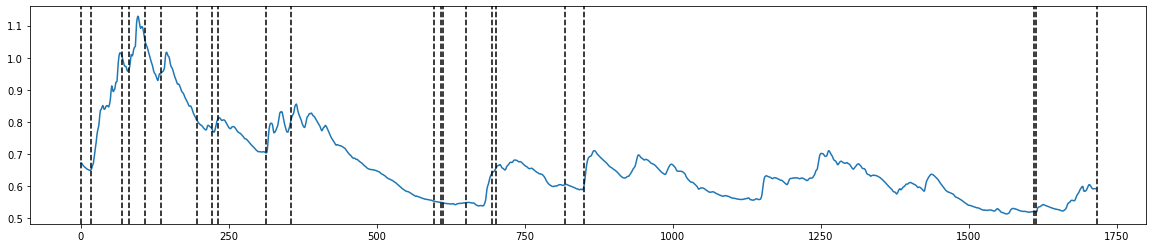

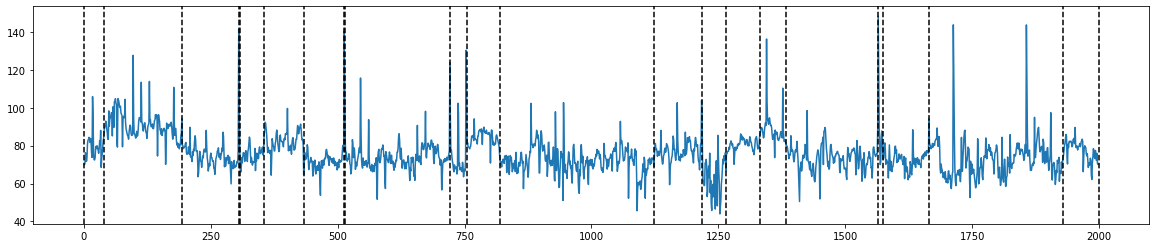

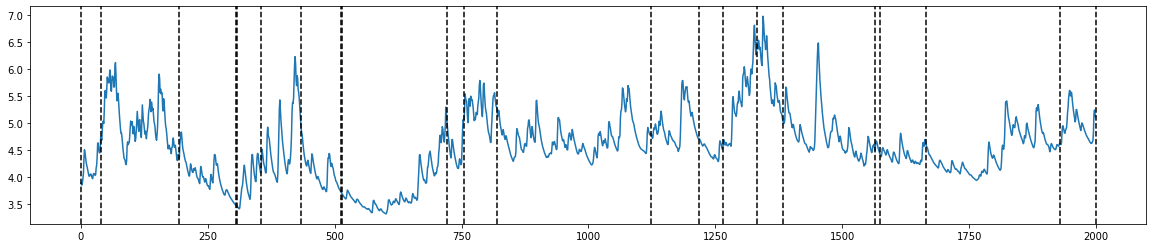

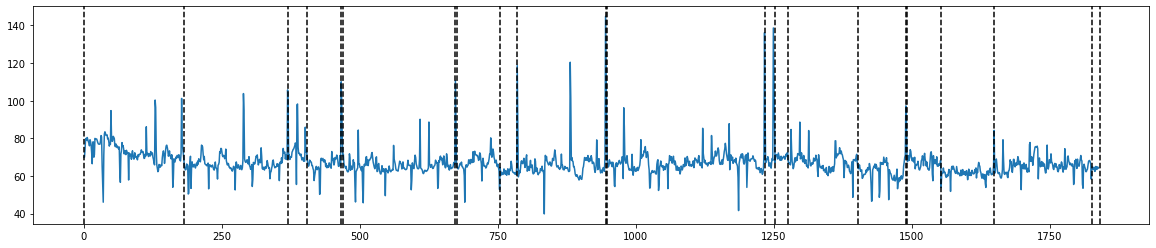

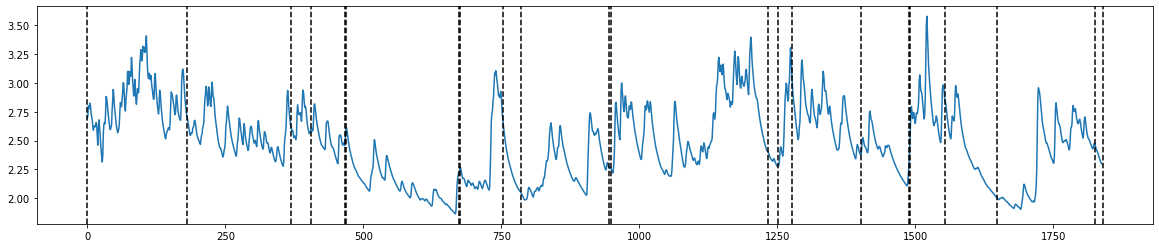

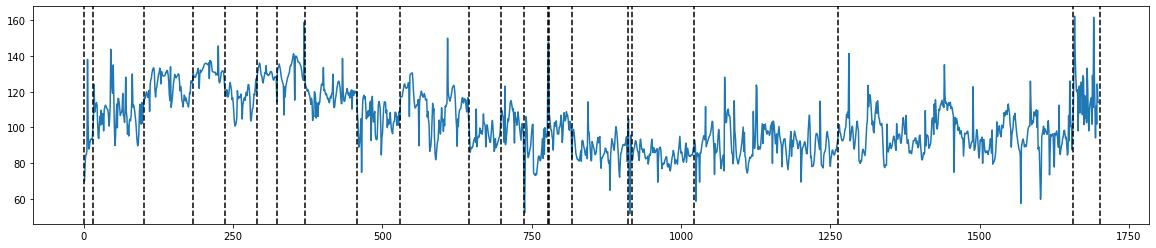

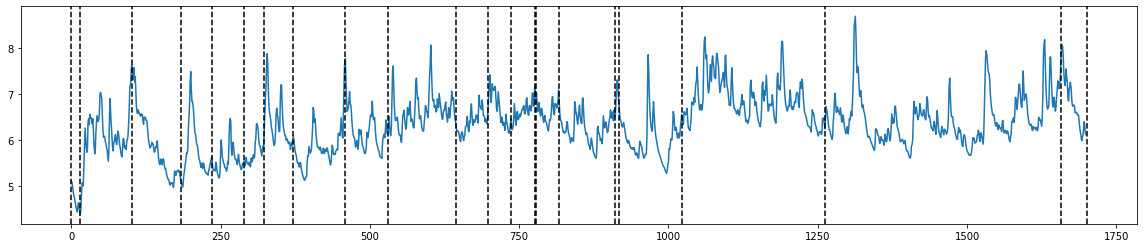

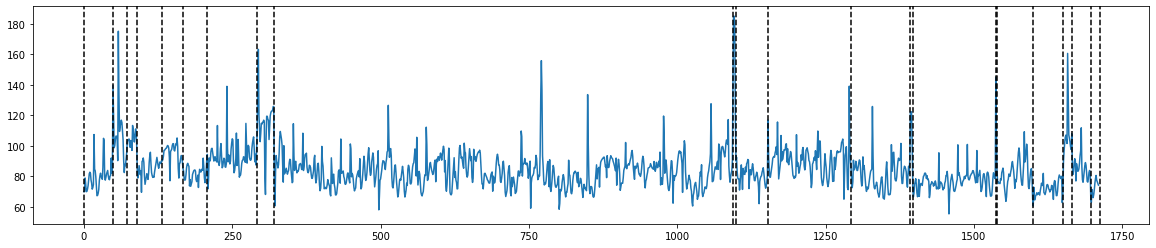

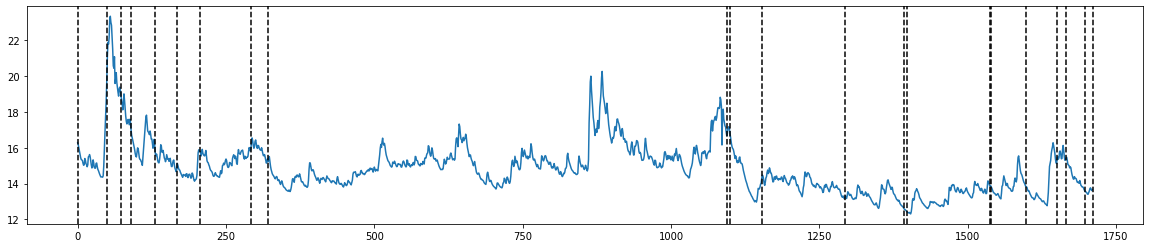

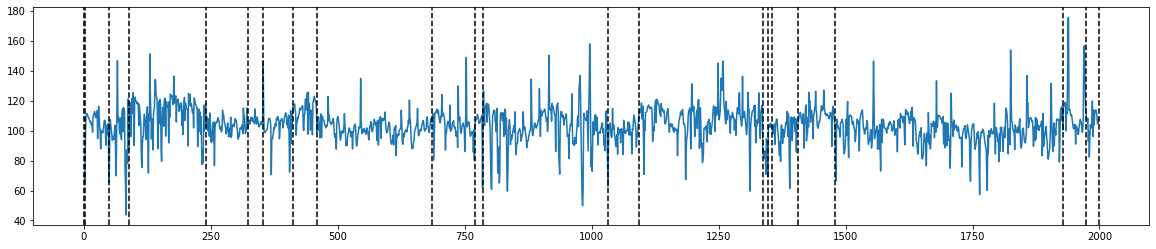

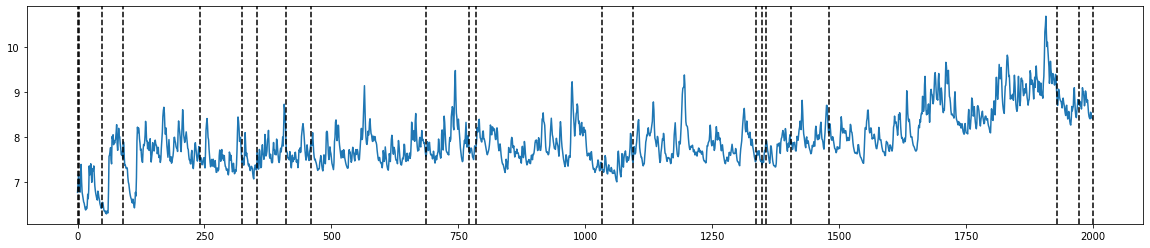

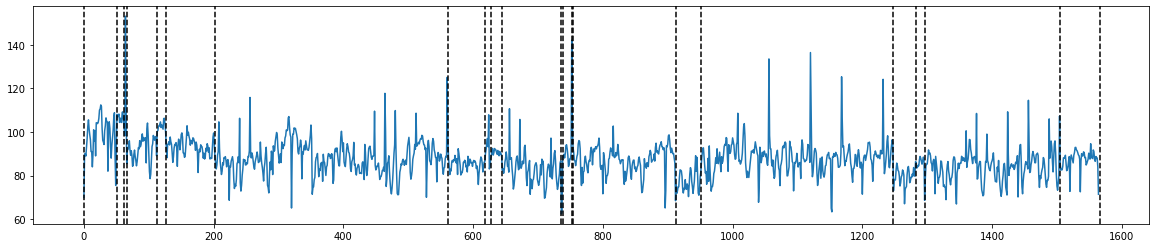

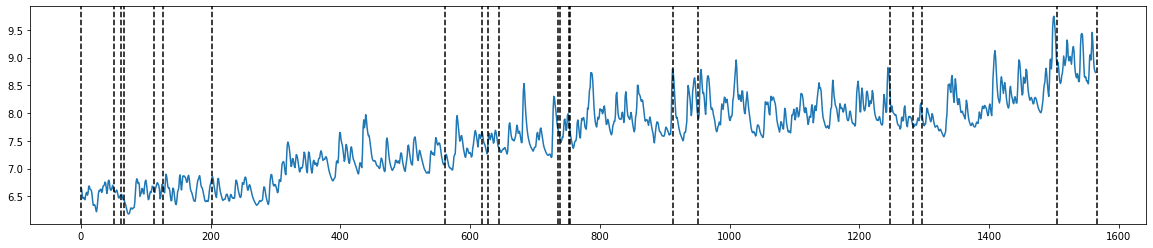

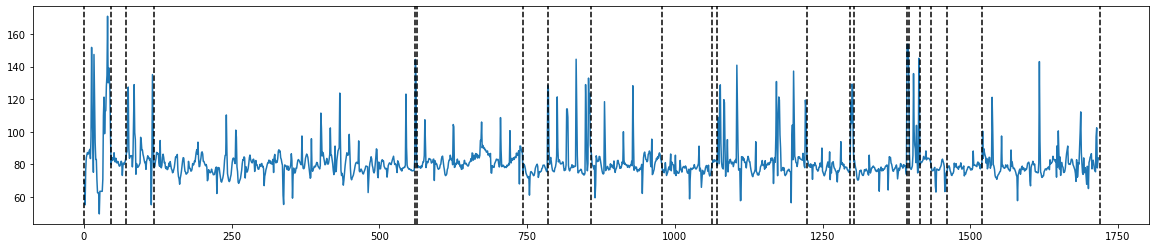

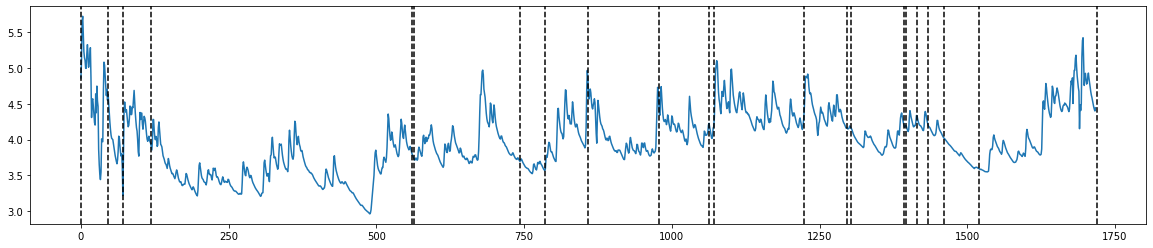

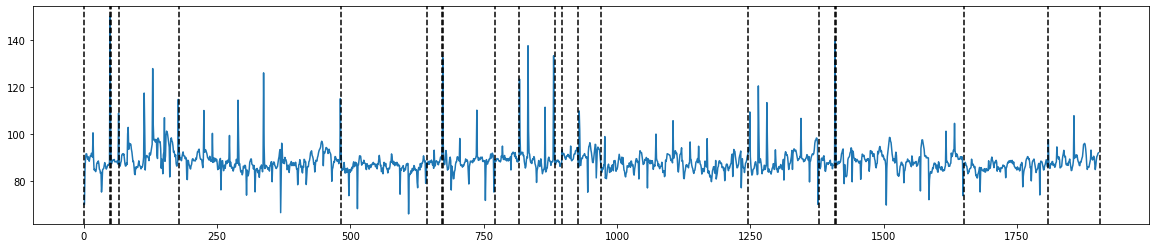

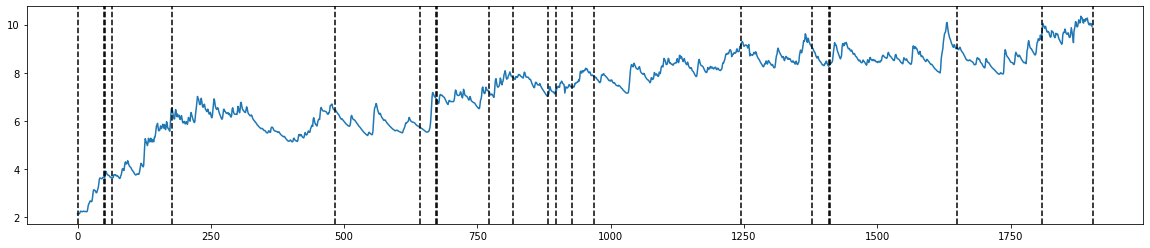

In [8]:
datapath, freq = "/home/kavra/Datasets/hcilab_driving_dataset/", "1S"
ggs_cols, comp_cols = ["HR"], ["SCR"]

for i in range(1, 11):
    path = datapath + f"participant_{i}.csv"
    data = pd.read_csv(path, delimiter=";")[
        ["Time_Light", "ECG", "HR", "HRV_LF", "SCR", "Speed_GPS", "AccelX", "AccelY", "AccelZ", "Rating_Videorating"]
    ]
    clean_data = process_ts(data, freq)
    this_data = clean_data[ggs_cols].to_numpy()
    bps, objectives = GGS(this_data.T, Kmax=20, lamb=5)

    plot_ggs(this_data, bps)
    plot_ggs(clean_data[comp_cols].to_numpy(), bps)

### MuSe

In [ ]:
muse_path = "/home/kavra/Repos/MuSe2022/muse_stress_2022/"
ft_path = muse_path + "feature_segments/"
lb_path = muse_path + "label_segments/physio-arousal/"
pt = pd.read_csv(muse_path + "metadata/partition.csv")

for p in os.listdir(ft_path + "BPM/")[::3]:
    ### label loading
    num = int(p.split(".")[0])
    if pt.loc[pt["Id"] == num]["Partition"].item() == "test":
        continue
    labels = pd.read_csv(lb_path + p)[["value"]].to_numpy()
    
    ### data loading
    bpm = pd.read_csv(ft_path + "BPM/" + p)[["BPM"]].to_numpy()
    rsp_r = pd.read_csv(ft_path + "resp_rate/" + p)[["resp_amp"]].to_numpy()
    rsp = pd.read_csv(ft_path + "resp/" + p)[["resp"]].to_numpy()

    ### ggs on streams
    data = bpm
    #data = np.hstack([bpm, rsp])
    bps, objectives = GGS(data.T, Kmax=10, lamb=1)
    plot_ggs(labels, bps)

### LIRIS ACCEDE (TBD)

<AxesSubplot:>

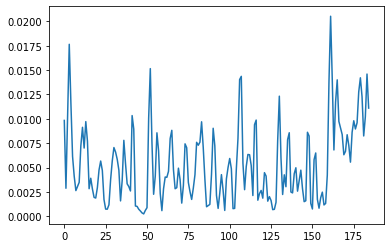

In [22]:
path = "/home/kavra/Datasets/LIRIS-ACCEDE/LIRIS-ACCEDE-continuous-physiological/continuous-physiological/The secret number.csv"
a = pd.read_csv(path, header=None, delimiter=";")
# 0: minutes 1: GSR 2: annotation
a[1].plot();

### RECOLA

In [7]:
def load_RECOLA_feat(path, sub="1"):
    data = arff.loadarff(f"{path}P{sub}.arff")
    return pd.DataFrame(data[0])

def load_AVEC_feat(path, partition, sub="1"):
    assert partition in ["train", "dev", "test"]
    data = arff.loadarff(f"{path}/{partition}_{sub}.arff")
    return pd.DataFrame(data[0])

def load_AVEC_rec(path, partition, sub="1"):
    assert partition in ["train", "dev", "test"]
    return pd.read_csv(f"{path}/{partition}_{sub}.csv", delimiter=";")

We are done adding breakpoints!
[0, 36, 61, 108, 172, 200, 513, 542, 556, 573, 606, 1280, 1369, 1395, 1409, 1434, 1502]


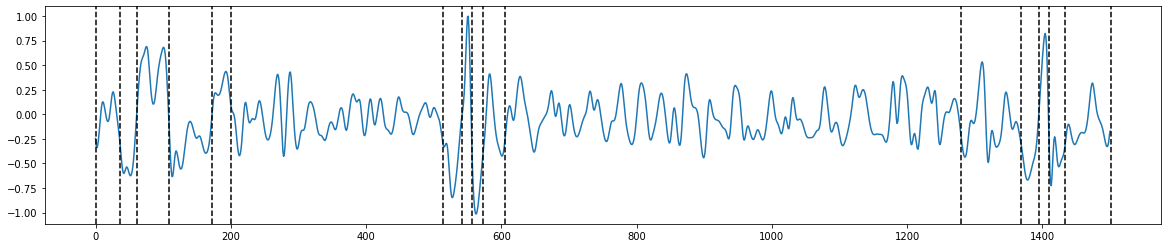

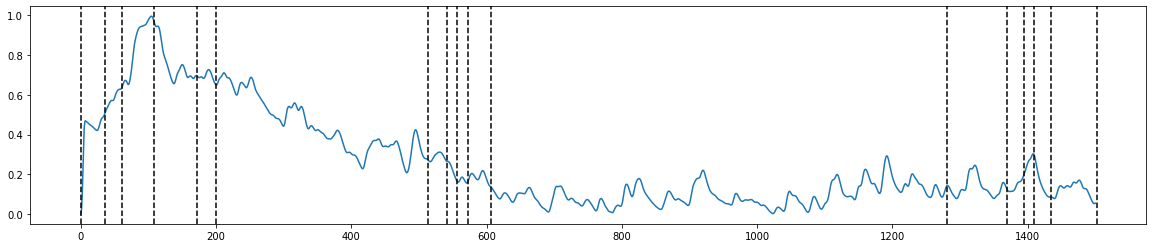

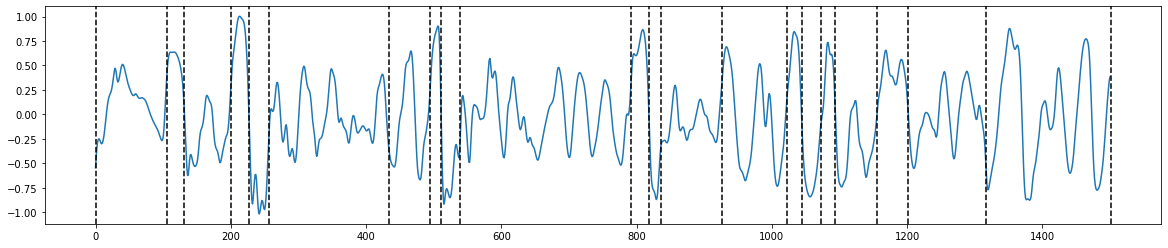

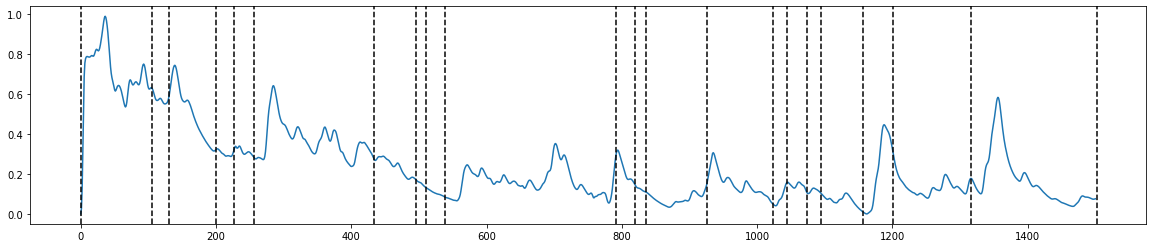

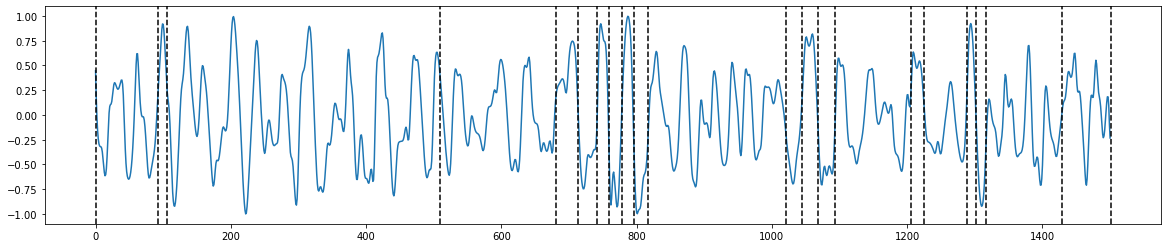

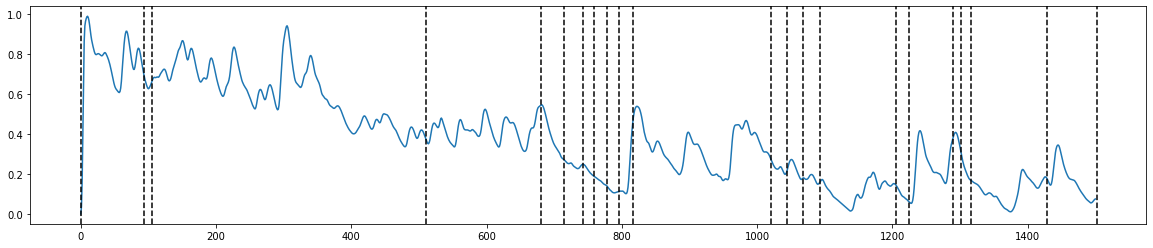

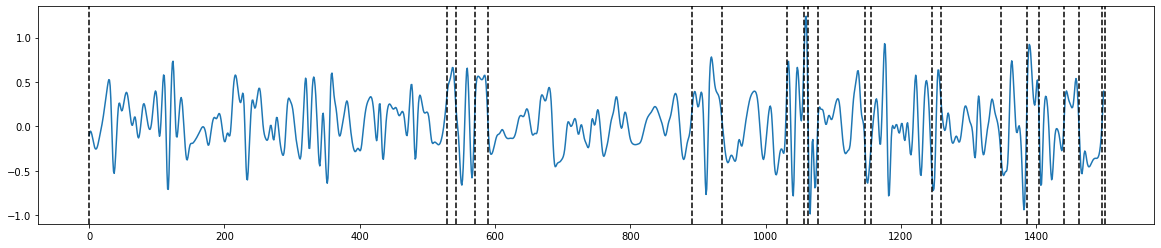

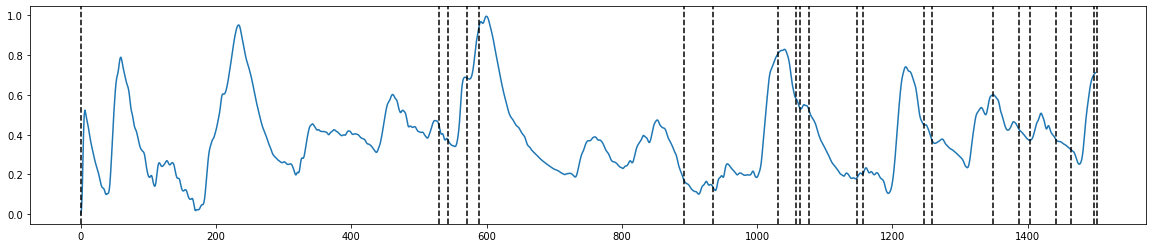

We are done adding breakpoints!
[0, 73, 100, 546, 563, 662, 680, 792, 835, 844, 881, 1502]


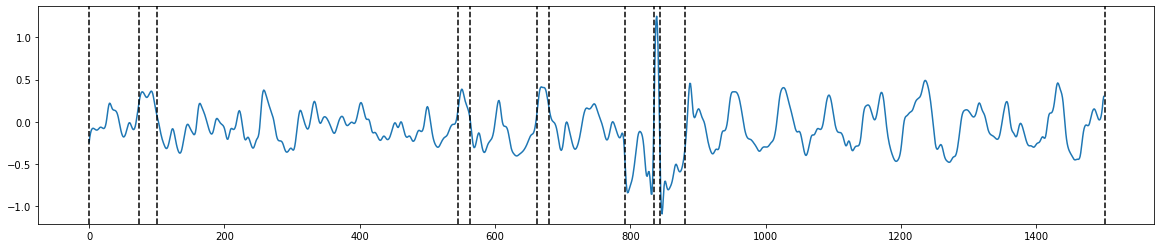

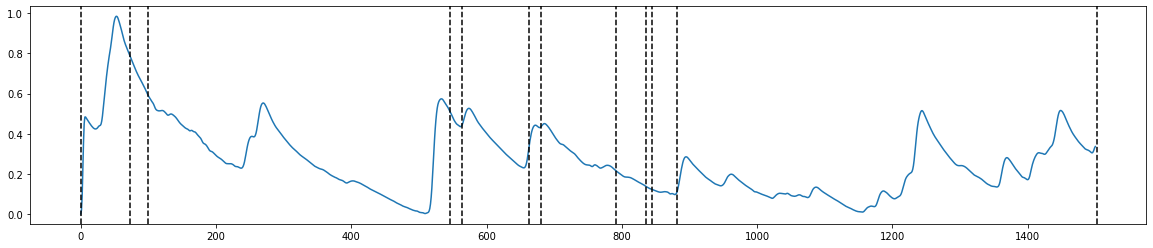

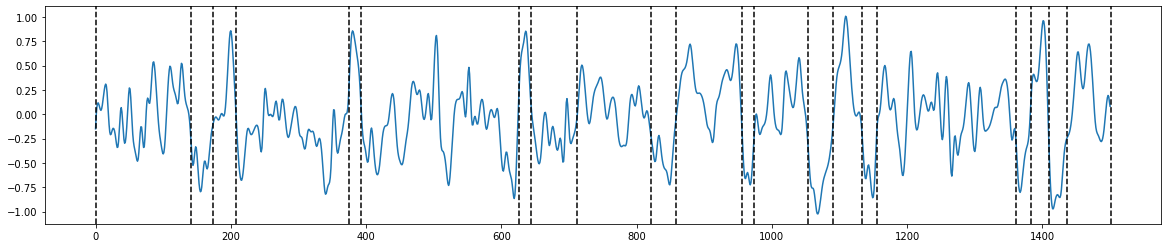

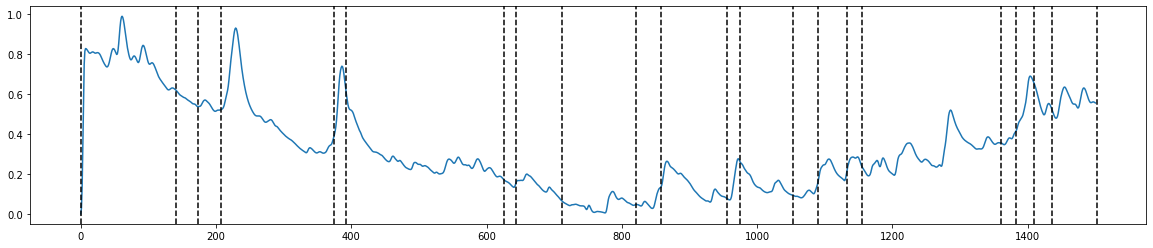

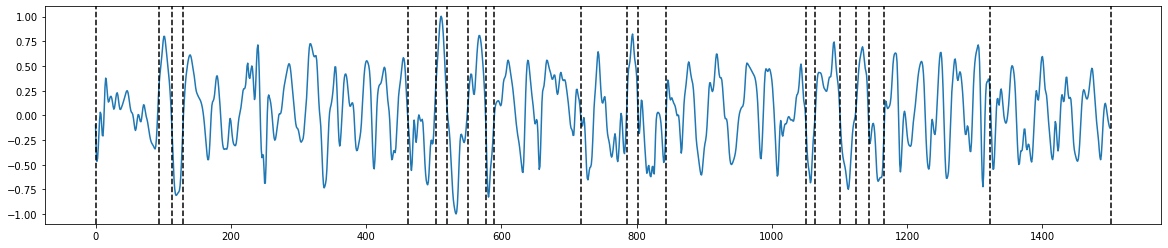

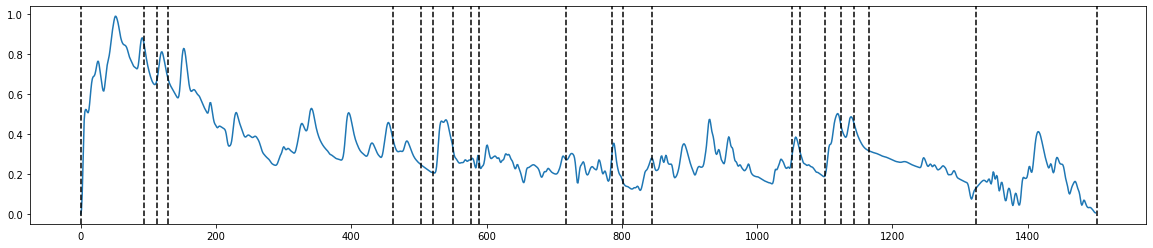

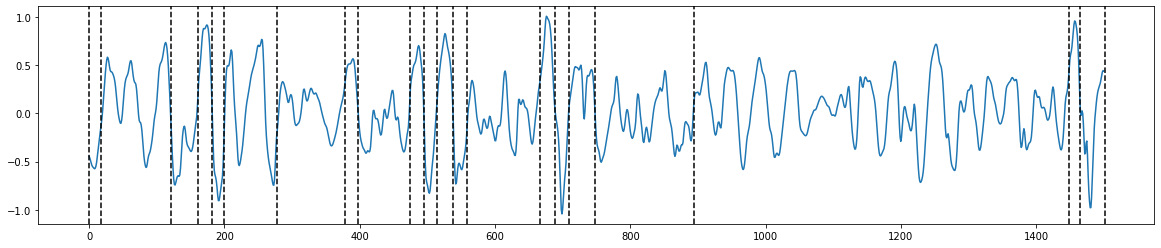

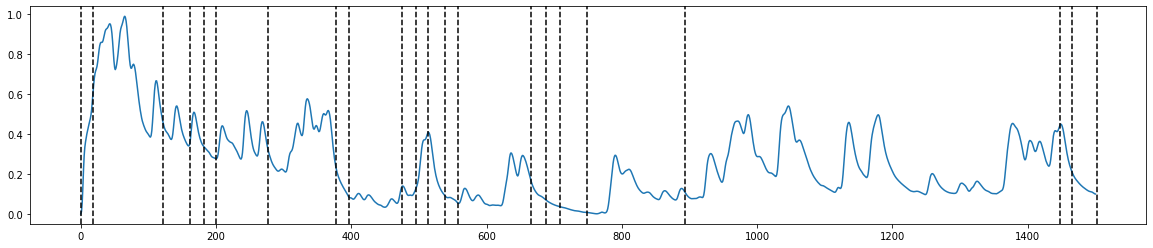

We are done adding breakpoints!
[0, 2, 16, 45, 58, 66, 78, 1502]


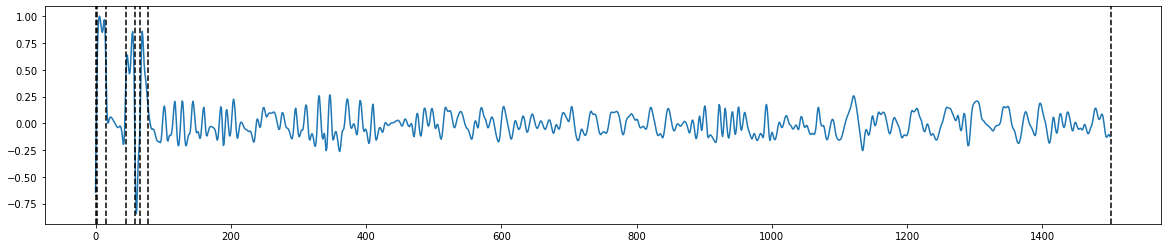

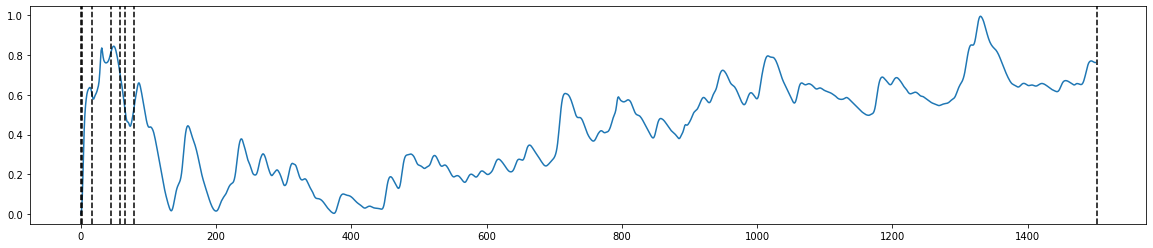

We are done adding breakpoints!
[0, 313, 318, 341, 363, 820, 1174, 1208, 1227, 1240, 1502]


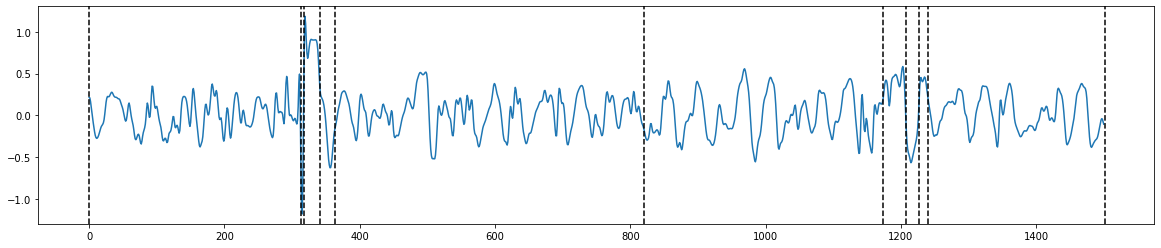

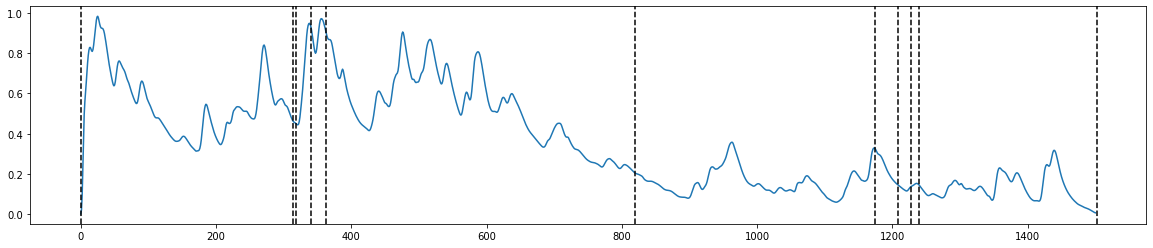

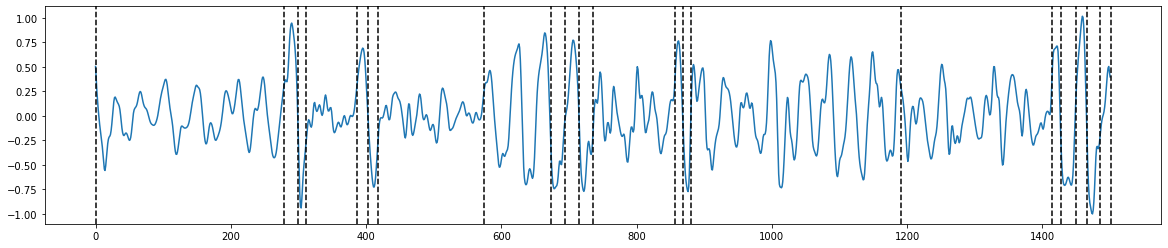

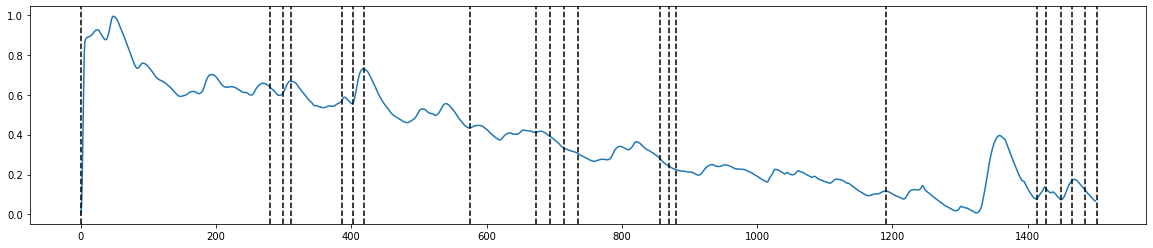

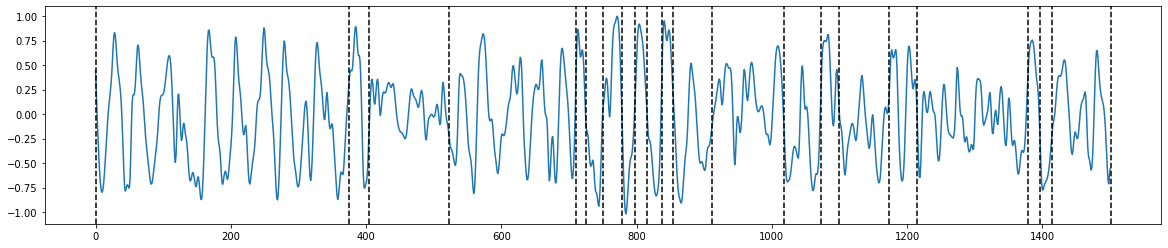

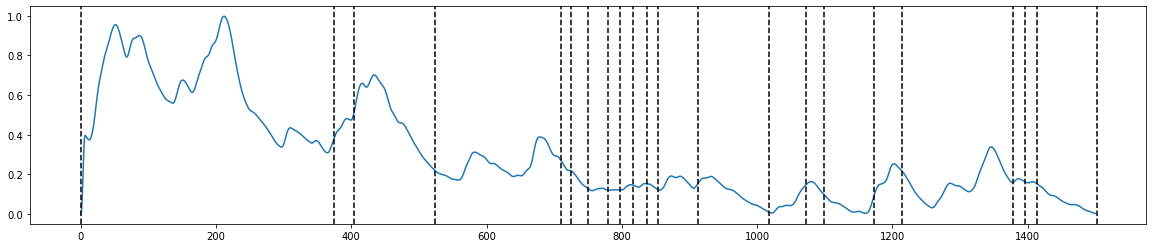

We are done adding breakpoints!
[0, 636, 641, 646, 651, 706, 1502]


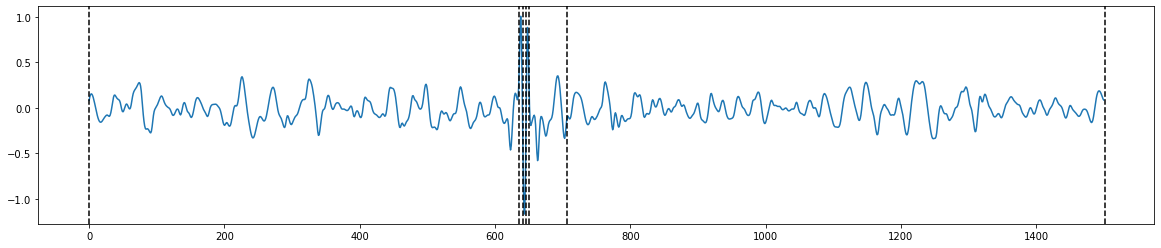

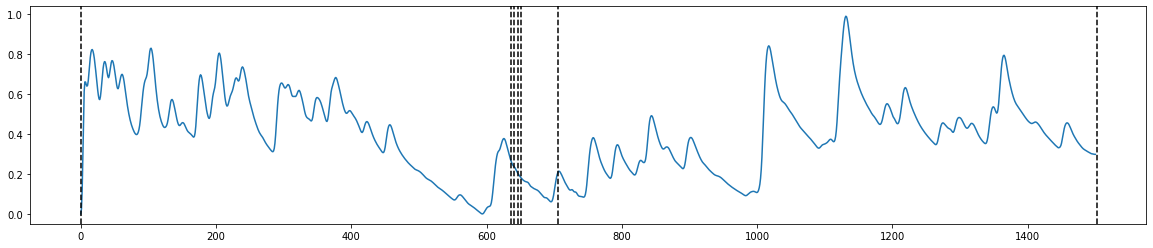

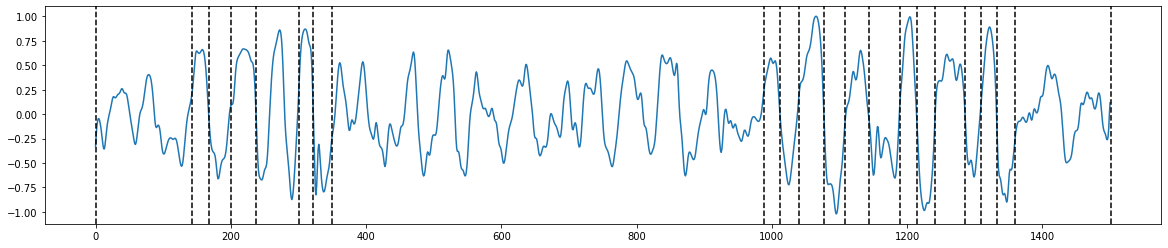

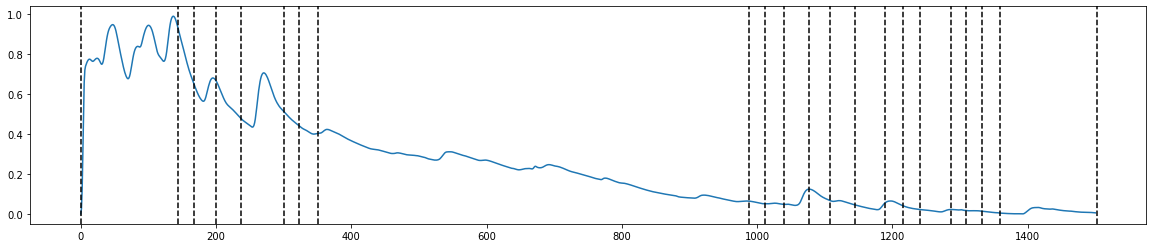

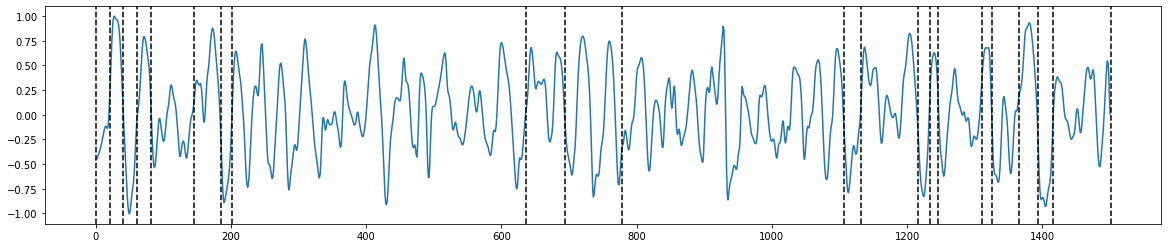

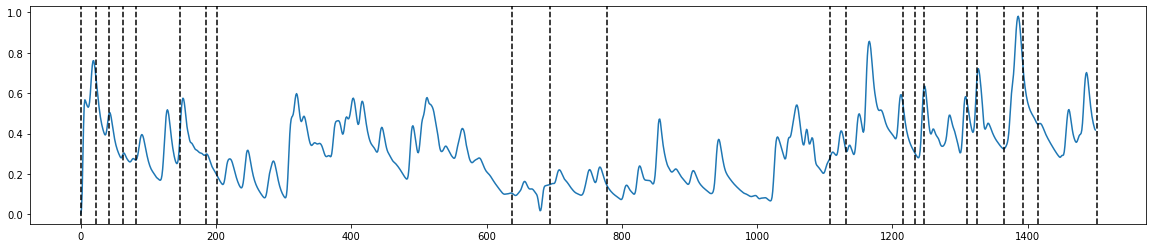

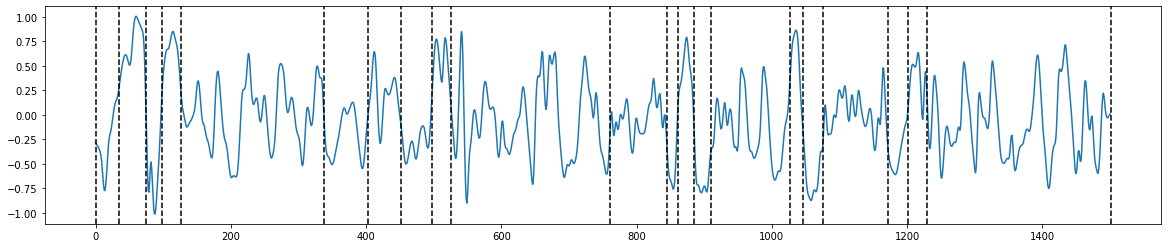

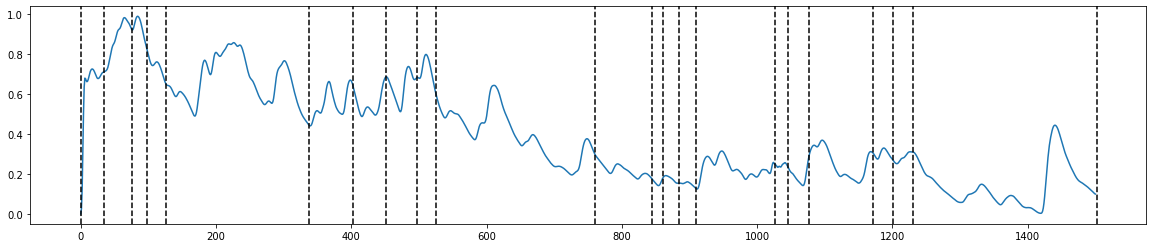

We are done adding breakpoints!
[0, 37, 70, 466, 472, 493, 528, 731, 783, 823, 965, 1225, 1242, 1307, 1317, 1379, 1385, 1397, 1404, 1414, 1502]


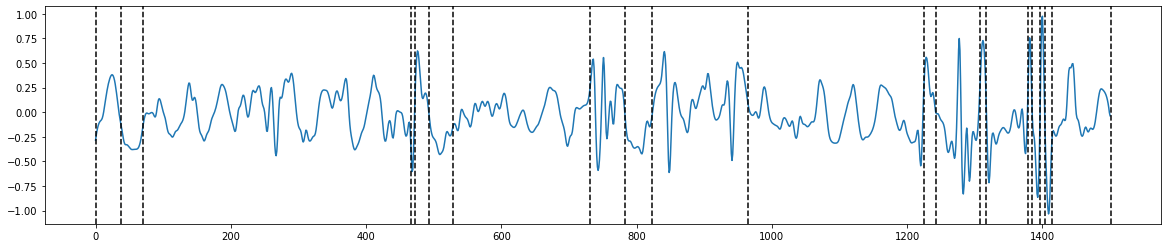

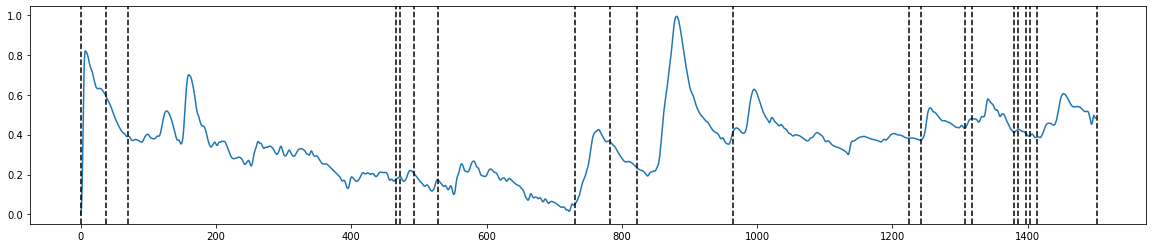

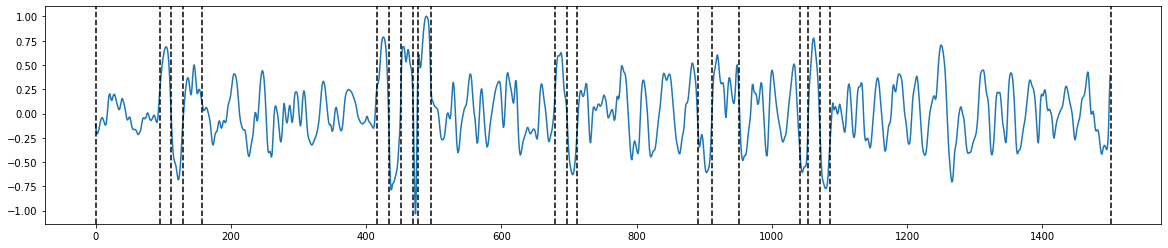

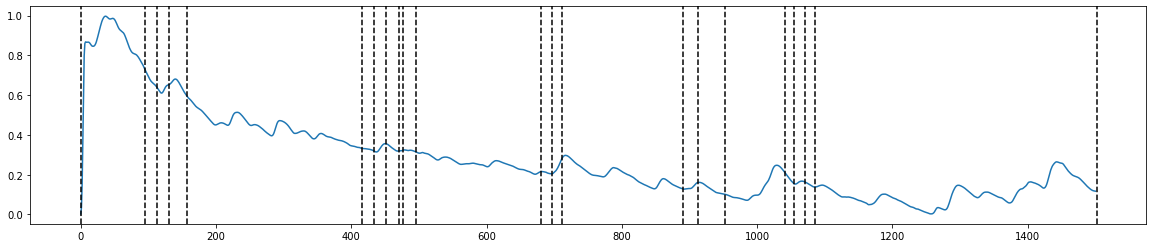

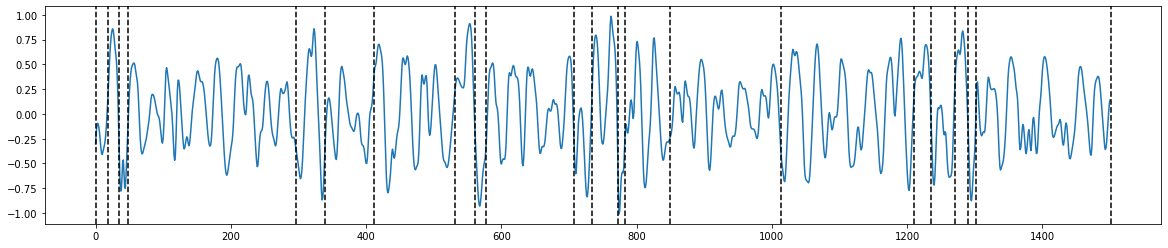

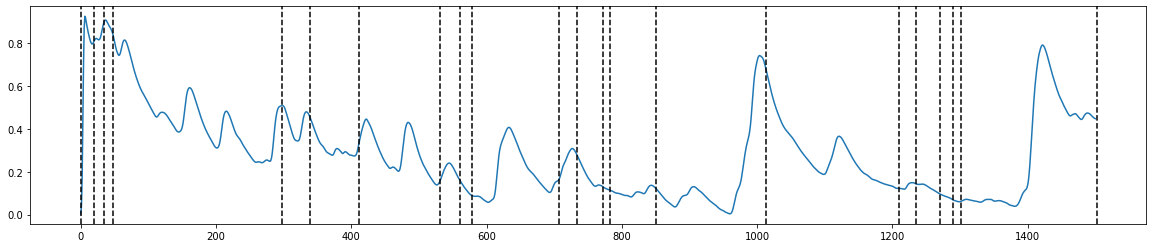

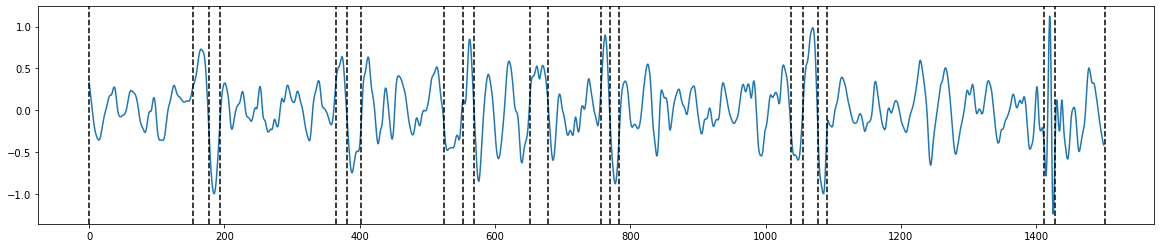

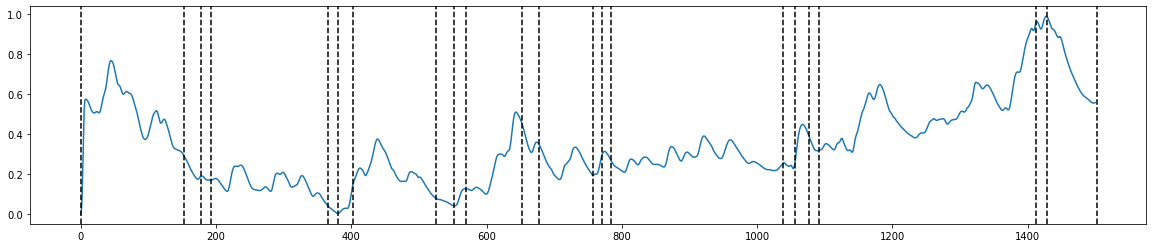

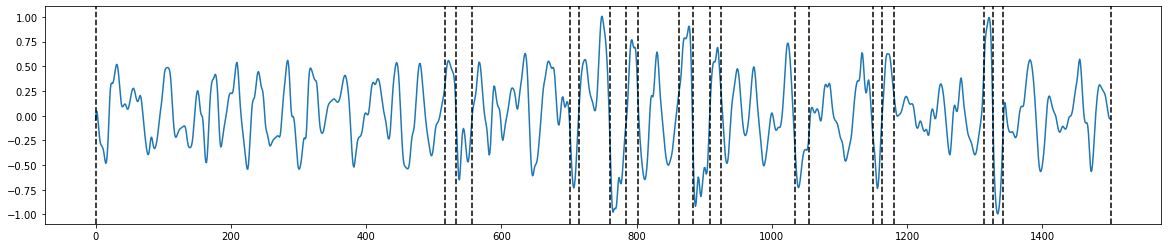

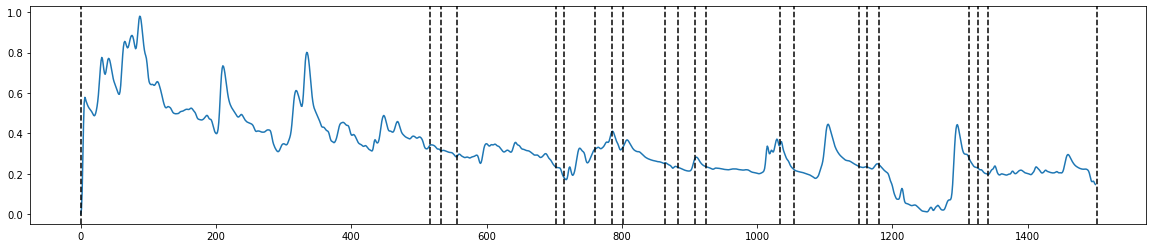

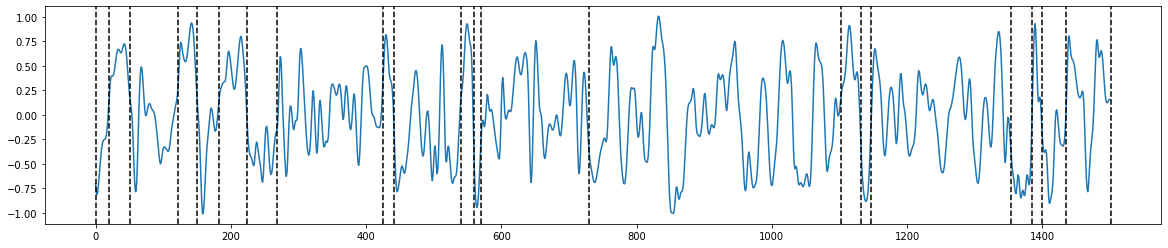

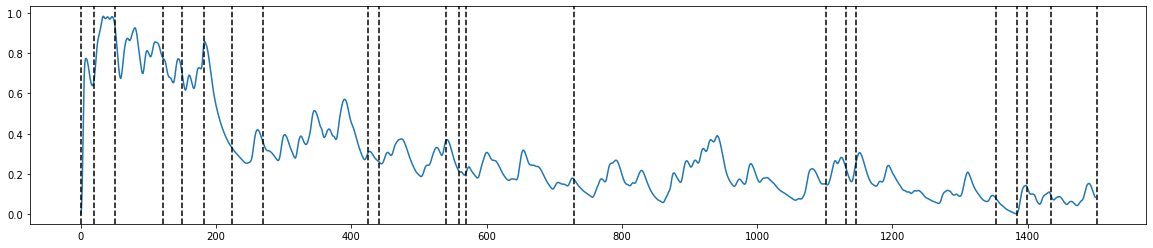

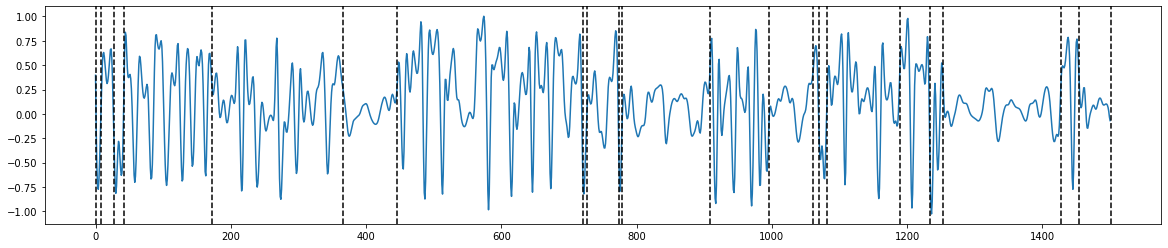

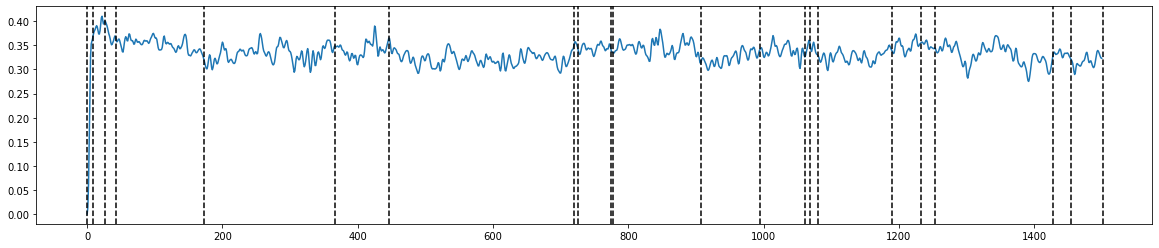

We are done adding breakpoints!
[0, 42, 53, 93, 104, 130, 329, 343, 355, 384, 648, 662, 668, 1376, 1389, 1409, 1433, 1443, 1470, 1479, 1502]


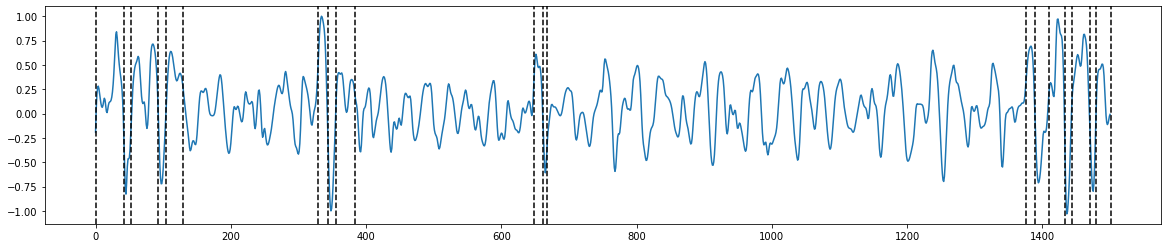

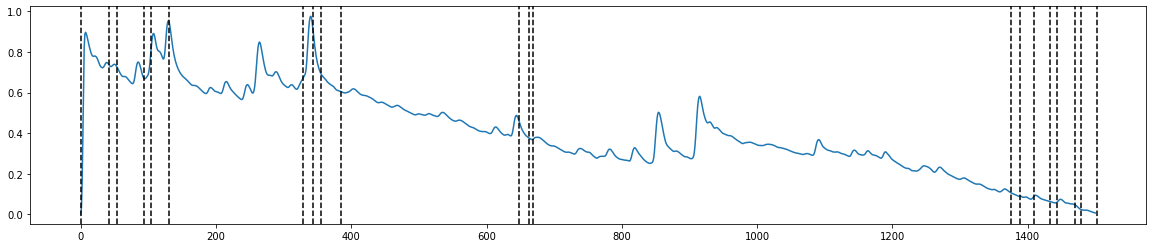

In [49]:
path = "/home/kavra/Datasets/RECOLA/AVEC16/recordings/recordings_physio/filtered/"
for partition in ["train", "dev", "test"]:
    for i in range(1, 9):
        # HRV being the 1st-order derivative of HR (from ECG)
        this_df = load_AVEC_rec(path, partition, sub=str(i))
        this_df.index = pd.date_range(start='1/1/2022', periods=len(this_df), freq='0.004S')
        this_df = this_df.resample("0.2S").mean()

        this_data = this_df[["HRV"]].to_numpy()
        this_data = this_data.T if len(this_data.shape) != 1 else this_data[None, ...]
        bps, _ = GGS(this_data, Kmax=20, lamb=5)

        plot_ggs(this_data.T, bps)
        plot_ggs(this_df["EDA"].to_numpy(), bps)